In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
import PIL
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
#connect to gdrive and mount it
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [7]:
# get the train & test folder path location in gdrive
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test  = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")


In [8]:
# Counting the images of Train and Test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


# Create Datasets

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
# Try the classical 80-20% Train and Test dataset approach

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_width,img_height),
                                                               batch_size=batch_size,validation_split=0.2,
                                                               subset='training',seed=123)##todo
train_ds

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_width,img_height),
                                                             batch_size=batch_size,validation_split=0.2,
                                                             subset='validation',seed=123)##todo
val_ds


Found 2249 files belonging to 9 classes.
Using 449 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Now Visualization of Data

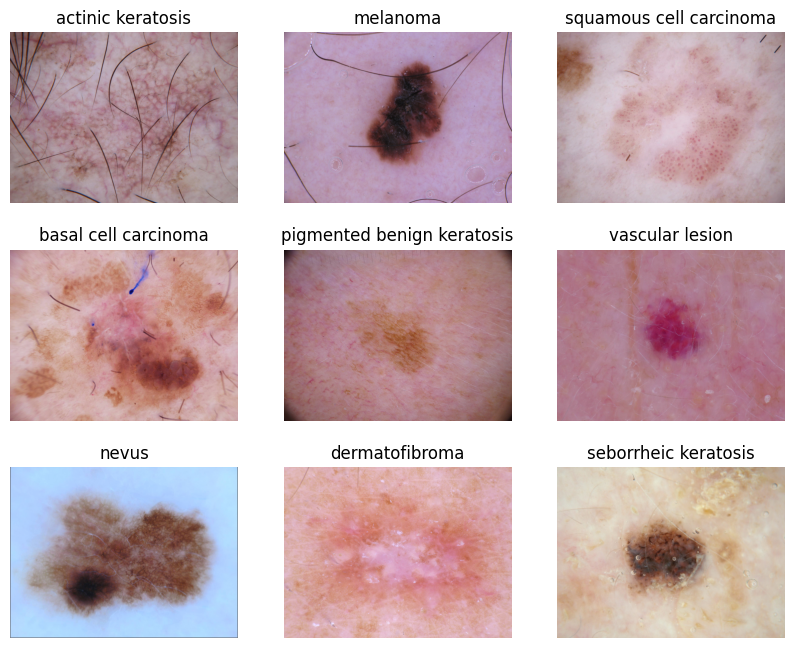

In [13]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

from PIL import Image
fig=plt.figure(figsize=(10,8))
counter=1
for f in data_dir_train.iterdir():
  im=Image.open(f.iterdir().__next__())
  plt.subplot(3,3,counter)
  plt.imshow(im)
  plt.title(str(f).split('/')[-1])
  counter+=1
  plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.



In [14]:
# Perform Autotuning
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Creation of the model

Creation of CNN model. Want to standardize the values

In [15]:
### Your code goes here

num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255,input_shape=(180,180,3)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#Compile the model

Choosing an appropriate optimiser model for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,659,081 (6.33 MB)

 Trainable params: 1,659,081 (6.33 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 339s 2s/step - accuracy: 0.2153 - loss: 2.0531 - val_accuracy: 0.3719 - val_loss: 1.6933
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.4208 - loss: 1.6398 - val_accuracy: 0.4588 - val_loss: 1.5350
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4808 - loss: 1.5020 - val_accuracy: 0.5234 - val_loss: 1.4744
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.5081 - loss: 1.4287 - val_accuracy: 0.4655 - val_loss: 1.4768
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.5262 - loss: 1.3070 - val_accuracy: 0.4677 - val_loss: 1.4332
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5591 - loss: 1.2465 - val_accuracy: 0.4677 - val_loss: 1.4571
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.5884 - loss: 1.1695 - val_accuracy: 0.5078 - val_loss: 1.4125
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.6180 - loss: 1.0603 - val_accuracy: 0.5078 - val_lo

# Visualizing training results

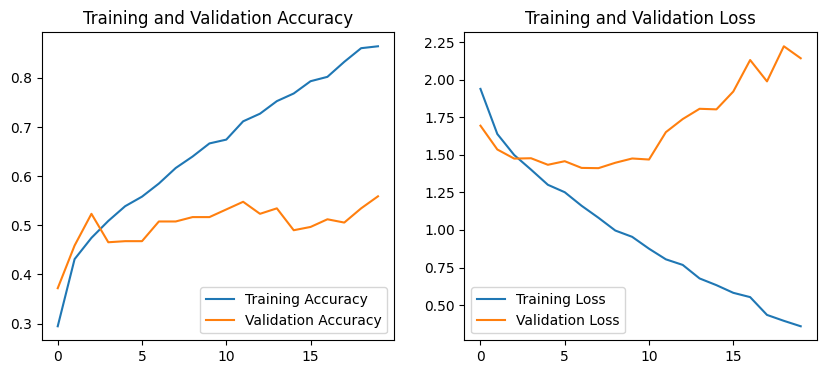

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Write your findings here
->There is clear evidence of model overfitting-

Training accuracy is 0.84 after 20 epochs but validation accuracy is 0.52 (difference of 0.32)
Training loss is going down after every epoch but validation loss is parabolic. In fact validation loss is going up.

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

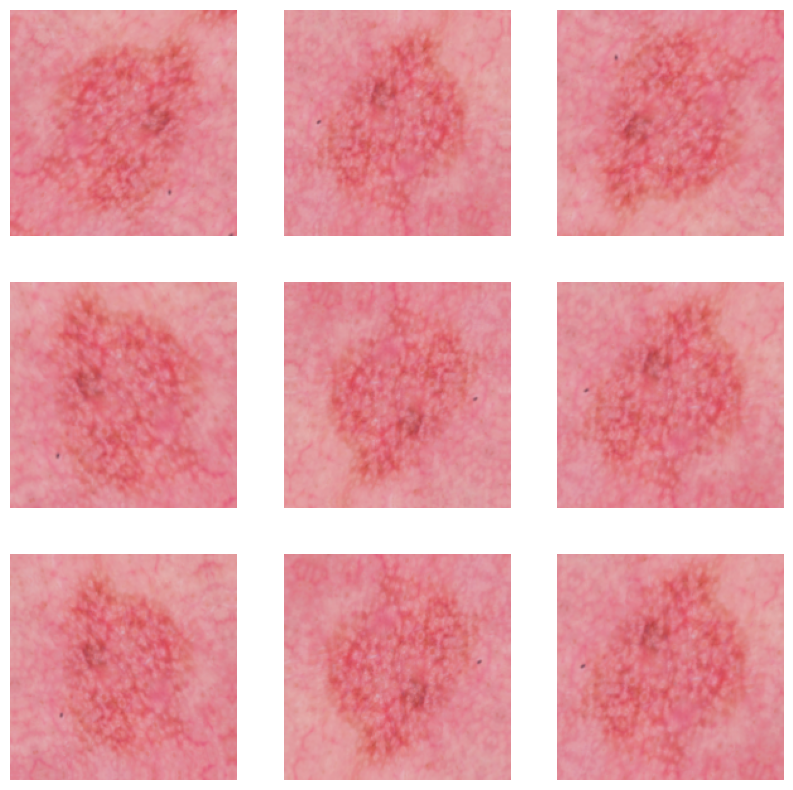

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for batch,labels in train_ds.take(1):
  im=batch[0]
  im=tf.reshape(im,(1,img_width,img_height,3))

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(im)[0]
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis("off")

Todo:
Create the model, compile and train the model

In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.1903 - loss: 2.2869 - val_accuracy: 0.2829 - val_loss: 2.0118
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.3045 - loss: 1.9161 - val_accuracy: 0.2806 - val_loss: 1.8975
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4149 - loss: 1.6808 - val_accuracy: 0.4677 - val_loss: 1.5625
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4156 - loss: 1.6383 - val_accuracy: 0.4677 - val_loss: 1.4917
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5062 - loss: 1.4522 - val_accuracy: 0.4477 - val_loss: 1.5731
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5037 - loss: 1.4579 - val_accuracy: 0.5145 - val_loss: 1.4232
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5210 - loss: 1.3872 - val_accuracy: 0.4922 - val_loss: 1.4364
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5358 - loss: 1.3398 - val_accuracy: 0.5212 - val_loss

Visualizing the results

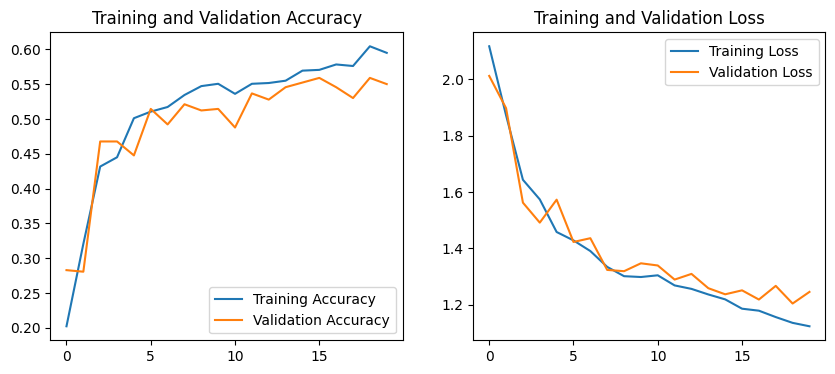

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
There is no evidence of overfitting. Training and validation accuraies are quite close (0.61, 0.54)

There is evidence of underfitting because training and validation accuracies are quite low (<0.7)

It looks like image augmentation got rid of overfitting

Todo: Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2249


In [27]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,448
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


Todo: Write your findings here:
- Which class has the least number of samples?
->seborrheic keratosis

- Which classes dominate the data in terms proportionate number of samples?
->pigmented benign keratosis

Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [29]:
path_to_training_dataset=str(data_dir_train)+'/'#'./Skin cancer ISIC The International Skin Imaging Collaboration/Train/'#"To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AE7BA30ACB0>: 100%|██████████| 500/500 [00:27<00:00, 17.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AE7B995BA30>: 100%|██████████| 500/500 [00:27<00:00, 18.22 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AE7BA38FD30>: 100%|██████████| 500/500 [00:27<00:00, 18.51 Samples/s]


Initialised with 448 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7AE7BA362650>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7AE7BA3BF520>: 100%|██████████| 500/500 [01:39<00:00,  5.05 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7AE7BA3DFBB0>: 100%|██████████| 500/500 [00:28<00:00, 17.33 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7AE7BA58BAF0>: 100%|██████████| 500/500 [00:52<00:00,  9.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AE7BA3AD750>: 100%|██████████| 500/500 [00:27<00:00, 18.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7AE7BA58BF70>: 100%|██████████| 500/500 [00:28<00:00, 17.35 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:2]

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_9f634990-a649-4e26-a69d-5cb345de8900.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_2b6c4852-c89f-4391-938c-7bfbc930e014.jpg']

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:2]

['actinic keratosis', 'actinic keratosis']

In [34]:

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [36]:
# Taking the new approach for dataframe.concat instead of append approach
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [37]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,948
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

Todo: Create a training dataset

In [39]:

data_dir_train=data_dir_train#"Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


Todo: Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


Todo: Create your model (make sure to include normalization)

In [41]:
## your code goes here

num_classes = 9

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

Todo: Compile your model (Choose optimizer and loss function appropriately)

In [42]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Todo: Train your model

In [43]:
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)# your model fit code

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.2104 - loss: 2.0958 - val_accuracy: 0.3855 - val_loss: 1.6108
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.4194 - loss: 1.5182 - val_accuracy: 0.4166 - val_loss: 1.4725
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.4662 - loss: 1.3912 - val_accuracy: 0.4848 - val_loss: 1.3126
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.4835 - loss: 1.3206 - val_accuracy: 0.5063 - val_loss: 1.2685
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5191 - loss: 1.2145 - val_accuracy: 0.5500 - val_loss: 1.1548
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.5350 - loss: 1.1787 - val_accuracy: 0.5174 - val_loss: 1.2637
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.5519 - loss: 1.1480 - val_accuracy: 0.5426 - val_loss: 1.2010
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.5599 - loss: 1.1258 - val_accu

Todo: Visualize the model results

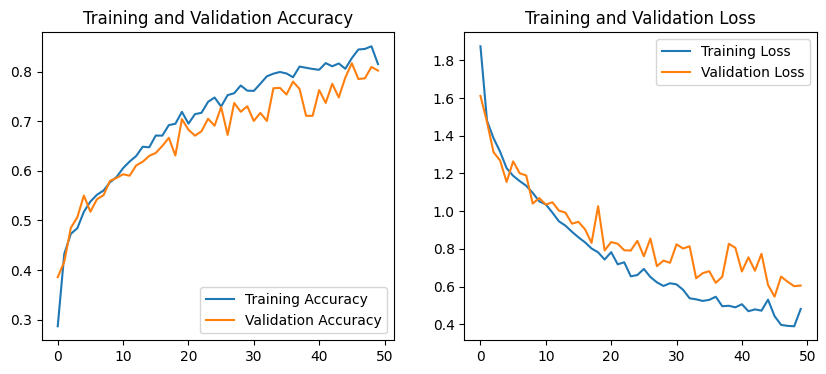

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
I got rid of underfitting. Now training and validation accuracies are higher than previous model (0.82, 0.79)

In [45]:
# Accuracy on Test data is not upto the mark

test_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,image_size=(img_width,img_height),
                                                            shuffle=False,batch_size=120)
predictions=model.predict(test_ds)
score = tf.nn.softmax(predictions)
_, labels = tuple(zip(*test_ds))
print(labels)
print()
print(np.argmax(score,axis=-1))
print()

from sklearn.metrics import accuracy_score
print('Test Accuracy')
accuracy_score(labels[0].numpy(),np.argmax(score,axis=-1))

Found 118 files belonging to 9 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
(<tf.Tensor: shape=(118,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8], dtype=int32)>,)

[3 4 4 7 0 7 1 4 0 4 7 4 4 7 4 7 1 7 1 1 1 1 1 5 1 1 5 1 7 1 1 5 3 4 5 3 3
 5 4 5 1 2 2 1 1 5 2 0 4 1 4 4 4 4 1 3 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 5 4 4 4 4 4 1 5 5 5 5 1 5 5 0 2 5 5 5 7 5 7 3 3 1 4 8 3 5 3 7 7 5 2 5 1 5
 0 7 7 1 8 1 8]

Test Accuracy


0.4152542372881356